<a href="https://colab.research.google.com/github/JyothyVariyampat/Benchmark-ML-and-DL-Models-for-Small-Molecule-Immunity-Target-Bioactivity-Prediction./blob/main/CW_AID_932.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#AID932_data_for_classification_08Nov202.csv

# PyTorch version: 2.6.0+cu124
# NumPy version: 1.24.4
# Pandas version: 2.2.2
# RDKit version: 2022.09.5

In [ ]:
# Environment setup
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Debug CUDA asserts
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [ ]:
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu118.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu118.html
# !pip install torch-geometric

#!pip install torch_geometric
!pip install torch-geometric==2.5.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.3 MB/s eta 0:00:00


In [ ]:
# prompt: nupy version

import numpy as np
np.__version__


'2.0.2'

In [ ]:
!pip install rdkit-pypi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 56.6 MB/s eta 0:00:00


In [ ]:
!pip install numpy==1.24.4
import os
os.kill(os.getpid(), 9)  # Restart the Colab runtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 97.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is 

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


MessageError: Error: credential propagation was unsuccessful

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, SanitizeMol
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.config import ModelConfig, ModelMode, ModelReturnType

In [ ]:
# from torch_geometric.explain import Explainer, GNNExplainer
# from torch_geometric.explain.config import ModelConfig, ModelMode, ModelReturnType


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Data loading and preprocessing
# def compute_rdkit_features(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         return None
#     try:
#         # Attempt to sanitize the molecule
#         SanitizeMol(mol)
#     except:
#         print(f"Failed to sanitize SMILES: {smiles}")
#         return None
#     return [
#         Descriptors.MolWt(mol),
#         Descriptors.MolLogP(mol),
#         Descriptors.TPSA(mol),
#         Descriptors.NumHDonors(mol),
#         Descriptors.NumHAcceptors(mol)
#     ]

from rdkit.Chem import Lipinski

def compute_rdkit_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        SanitizeMol(mol)
    except:
        print(f"Failed to sanitize SMILES: {smiles}")
        return None

    # Compute updated concept descriptors
    return [
        Descriptors.TPSA(mol),                  # 1. Topological Polar Surface Area
        Descriptors.MolLogP(mol),               # 2. LogP
        Descriptors.NumHDonors(mol),            # 3. Hydrogen Bond Donors
        #Lipinski.NumAromaticRings(mol),         # 4. Number of Aromatic Rings
        Descriptors.NumRotatableBonds(mol),     # 4. NumRotatableBonds
        Descriptors.MolMR(mol)                  # 5. Molar Refractivity
    ]



# def mol_to_graph(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         return None
#     G = nx.Graph()
#     for atom in mol.GetAtoms():
#         G.add_node(atom.GetIdx(), x=torch.tensor([atom.GetAtomicNum()], dtype=torch.float))
#     for bond in mol.GetBonds():
#         start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
#         G.add_edge(start, end)
#     data = from_networkx(G)
#     data.x = torch.stack([feat["x"] for _, feat in G.nodes(data=True)])
#     return data

def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), x=torch.tensor([atom.GetAtomicNum()], dtype=torch.float))
    edge_indices = []
    edge_attrs = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        G.add_edge(start, end)
        edge_indices.append((start, end))
        edge_indices.append((end, start))  # For undirected graph
        bond_type = bond.GetBondTypeAsDouble()  # Simplified edge feature
        edge_attrs.append([bond_type])
        edge_attrs.append([bond_type])
    data = from_networkx(G)
    data.x = torch.stack([feat["x"] for _, feat in G.nodes(data=True)])
    data.edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    data.edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
    return data


def load_dataset(csv_path):
    df = pd.read_csv(csv_path)
    dataset, failed = [], 0
    for idx, row in df.iterrows():
        smiles = row['SMILES']
        label = 1 if row['PUBCHEM_ACTIVITY_OUTCOME'].lower() == 'active' else 0
        features = compute_rdkit_features(smiles)
        graph = mol_to_graph(smiles)
        if features is None or graph is None:
            failed += 1
            continue
        graph.y = torch.tensor(label, dtype=torch.long)
        graph.mol_features = torch.tensor(features, dtype=torch.float)
        dataset.append(graph)
    print(f"Processed {len(dataset)} molecules. Failed: {failed}")
    return dataset, df

In [ ]:
# CHANGE THIS PATH to your CSV file
csv_path = "/content/AID932_data_for_classification_08Nov2024 (1).csv"
dataset, df_raw = load_dataset(csv_path)

Processed 4000 molecules. Failed: 0


In [ ]:
# Data splitting
train_idx, test_idx = train_test_split(
    range(len(dataset)), test_size=0.2,
    stratify=[data.y.item() for data in dataset], random_state=42)

train_set = [dataset[i] for i in train_idx]
test_set = [dataset[i] for i in test_idx]

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64)


In [ ]:
# Model definition
from torch_geometric.nn import AttentiveFP

# Define Concept Whitening Layer
class ConceptWhiteningLayer(nn.Module):
    def __init__(self, input_dim, concept_dim):
        super().__init__()
        self.proj = nn.Linear(input_dim, concept_dim)
        self.R = nn.Parameter(torch.eye(concept_dim), requires_grad=True)

    def forward(self, x, concept_vectors):
        x_centered = x - x.mean(dim=0, keepdim=True)
        concept_space = self.proj(x_centered)
        aligned = concept_space @ self.R
        self.loss = F.mse_loss(aligned, concept_vectors) if concept_vectors is not None else torch.tensor(0.0, device=x.device)
        return aligned

class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return x

class GCNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_dim, concept_dim, num_classes):
        super().__init__()
        self.encoder = GCNEncoder(in_channels, hidden_dim)
        self.pool = global_mean_pool
        self.cw_layer = ConceptWhiteningLayer(hidden_dim, concept_dim)
        self.fc = nn.Linear(concept_dim, num_classes)

    def forward(self, data):
        x = self.encoder(data.x, data.edge_index)
        x = self.pool(x, data.batch)
        mol_concepts = data.mol_features.view(x.size(0), -1)
        x = self.cw_layer(x, mol_concepts)
        return self.fc(x), self.cw_layer.loss

In [ ]:
# Training functions
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, align_loss = model(data)
        cls_loss = F.cross_entropy(out, data.y)
        loss = cls_loss + align_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    for data in loader:
        data = data.to(device)
        out, _ = model(data)
        prob = F.softmax(out, dim=1)[:, 1]
        pred = out.argmax(dim=1)
        y_true += data.y.cpu().tolist()
        y_pred += pred.cpu().tolist()
        y_prob += prob.cpu().tolist()
    return accuracy_score(y_true, y_pred), roc_auc_score(y_true, y_prob)


In [ ]:
# Model, optimizer initialization
in_channels = dataset[0].x.shape[1]
model = GCNClassifier(in_channels, 128, 5, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
# Training loop
for epoch in range(1, 31):
    loss = train(model, train_loader, optimizer)
    acc, roc = evaluate(model, test_loader)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Accuracy: {acc:.4f} | ROC-AUC: {roc:.4f}")


Epoch 01 | Loss: 2709.0353 | Accuracy: 0.5000 | ROC-AUC: 0.5031
Epoch 02 | Loss: 2708.5771 | Accuracy: 0.5000 | ROC-AUC: 0.5032
Epoch 03 | Loss: 2708.1139 | Accuracy: 0.5000 | ROC-AUC: 0.5032
Epoch 04 | Loss: 2707.6385 | Accuracy: 0.5000 | ROC-AUC: 0.5032
Epoch 05 | Loss: 2707.1521 | Accuracy: 0.5000 | ROC-AUC: 0.5032
Epoch 06 | Loss: 2706.6489 | Accuracy: 0.5000 | ROC-AUC: 0.5033
Epoch 07 | Loss: 2706.1243 | Accuracy: 0.5000 | ROC-AUC: 0.5033
Epoch 08 | Loss: 2705.5795 | Accuracy: 0.5000 | ROC-AUC: 0.5033
Epoch 09 | Loss: 2705.0061 | Accuracy: 0.5000 | ROC-AUC: 0.5033
Epoch 10 | Loss: 2704.3997 | Accuracy: 0.5000 | ROC-AUC: 0.5033
Epoch 11 | Loss: 2703.7745 | Accuracy: 0.5000 | ROC-AUC: 0.5033
Epoch 12 | Loss: 2703.0970 | Accuracy: 0.5000 | ROC-AUC: 0.5033
Epoch 13 | Loss: 2702.3992 | Accuracy: 0.5000 | ROC-AUC: 0.5032
Epoch 14 | Loss: 2701.6399 | Accuracy: 0.5000 | ROC-AUC: 0.5032
Epoch 15 | Loss: 2700.8580 | Accuracy: 0.5062 | ROC-AUC: 0.5033
Epoch 16 | Loss: 2700.0689 | Accuracy: 0


 Running Explainability on Last 5 Molecules...

🔬 Molecule 796
SMILES: CCOC(=O)C1=C(C2=C(N1)C=CC(=C2)OC)C
TPSA: 51.320
LogP: 2.662
NumHDonors: 1.000
NumRotatableBonds: 3.000
MolMR: 65.544
Node mask has constant values. Skipping visualization.


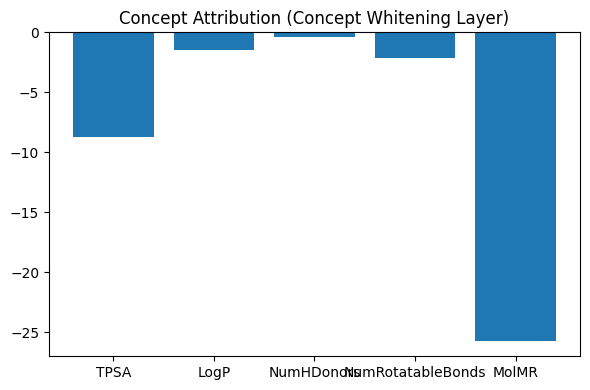


🔬 Molecule 797
SMILES: CC1=CC(=C(C(=C1)C)S(=O)(=O)N2C=CC3=CC=CC=C32)C
TPSA: 39.070
LogP: 3.804
NumHDonors: 0.000
NumRotatableBonds: 2.000
MolMR: 85.175
Node mask has constant values. Skipping visualization.


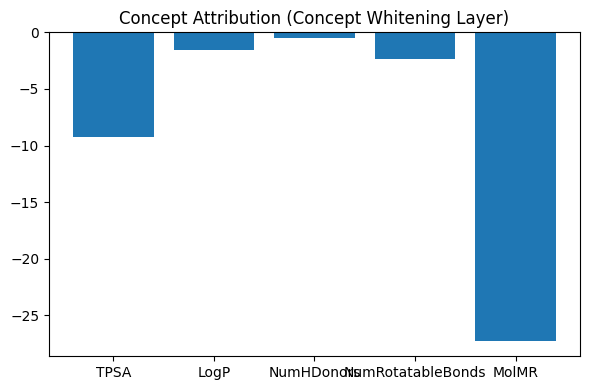


🔬 Molecule 798
SMILES: CCOC(=O)C1=CC=C(C=C1)N2CC(=C(C2=N)C3=NC4=CC=CC=C4C(=O)N3)O
TPSA: 119.370
LogP: 2.866
NumHDonors: 3.000
NumRotatableBonds: 4.000
MolMR: 109.384
Node mask has constant values. Skipping visualization.


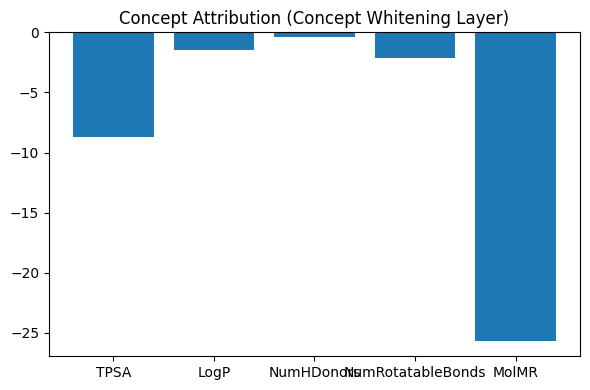


🔬 Molecule 799
SMILES: CCS(=O)(=O)N1CCN(CC1)S(=O)(=O)C2=CC=CC=C2.C(=O)(C(=O)O)O
TPSA: 149.360
LogP: -0.502
NumHDonors: 2.000
NumRotatableBonds: 4.000
MolMR: 91.506
Node mask has constant values. Skipping visualization.


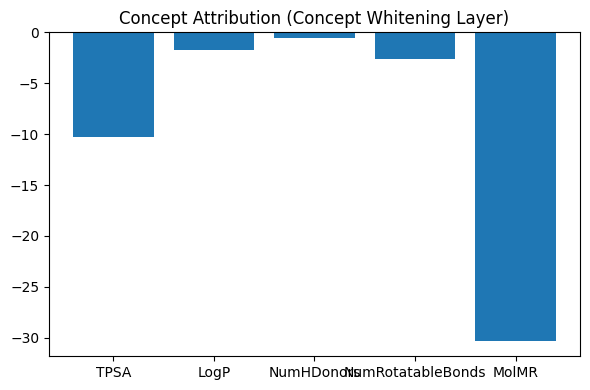


🔬 Molecule 800
SMILES: CC(=O)NC1=CC2=C(C=C1)C(=O)C3=CC=CC=C3C2=O
TPSA: 63.240
LogP: 2.420
NumHDonors: 1.000
NumRotatableBonds: 1.000
MolMR: 74.053
Node mask has constant values. Skipping visualization.


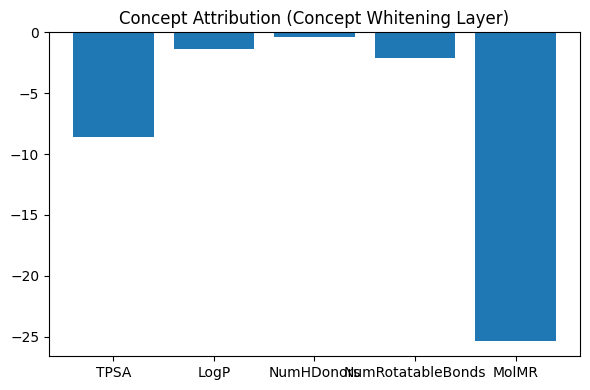

In [ ]:
# Explanation utilities
class WrappedModel(nn.Module):
    def __init__(self, base_model, mol_features):
        super().__init__()
        self.base_model = base_model
        self.mol_features = mol_features

    def forward(self, x, edge_index, batch, **kwargs):
        data = Data(x=x, edge_index=edge_index, batch=batch)
        data.mol_features = self.mol_features
        out, _ = self.base_model(data)
        return out

def visualize_rdkit_colored(smiles, node_mask):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("Invalid SMILES:", smiles)
        return

    try:
        node_mask = node_mask.cpu().detach().numpy()

        # Handle NaN or Inf values
        if np.isnan(node_mask).any() or np.isinf(node_mask).any():
            print("Node mask contains NaN or Inf values. Skipping visualization.")
            return

        # Avoid division by zero
        if np.allclose(node_mask.max(), node_mask.min()):
            print("Node mask has constant values. Skipping visualization.")
            return

        # Normalize node mask
        node_mask = (node_mask - node_mask.min()) / (node_mask.max() - node_mask.min() + 1e-8)
        atom_weights = {i: float(node_mask[i]) for i in range(len(node_mask))}

        # Generate the image
        img = Draw.MolToImage(
            mol,
            size=(400, 300),
            highlightAtoms=list(atom_weights.keys()),
            highlightAtomColors={i: (1.0, 0.5 * w, 0.5 * w) for i, w in atom_weights.items()},
        )

        plt.figure(figsize=(4, 3))
        plt.imshow(img)
        plt.axis('off')
        plt.title("RDKit Atom Attribution Map")
        plt.show()

    except Exception as e:
        print("RDKit Visualization Error:", e)

def plot_concept_importance(model, data, device, concept_names=None):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = model.encoder(x, edge_index)
        x = model.pool(x, batch)
        concepts = model.cw_layer.proj(x) @ model.cw_layer.R
        concepts = concepts[0].cpu().numpy()

    if concept_names is None:
        concept_names = ["TPSA", "LogP", "NumHDonors", "NumRotatableBonds", "MolMR"]




    plt.figure(figsize=(6, 4))
    plt.bar(concept_names, concepts)
    plt.title("Concept Attribution (Concept Whitening Layer)")
    plt.tight_layout()
    plt.show()

# Explanation loop
# print("\nRunning Explainability on Last 5 Molecules...")
# last_five_indices = list(range(len(test_set) - 5, len(test_set)))

# for i in last_five_indices:
#     print(f"\n Molecule {i+1}")
#     sample = test_set[i].to(device)

#     # Skip small molecules
#     if len(sample.x) < 3:
#         print("Skipping molecule with too few atoms")
#         continue

#     try:
#         wrapped_model = WrappedModel(model, mol_features=sample.mol_features).to(device)  # Ensure model is on the same device
#         explainer = Explainer(
#             model=wrapped_model,
#             algorithm=GNNExplainer(epochs=200),
#             explanation_type='model',
#             node_mask_type='attributes',
#             edge_mask_type='object',
#             model_config=ModelConfig(
#                 mode=ModelMode.binary_classification,
#                 task_level='graph',
#                 return_type=ModelReturnType.probs,
#             )
#         )

#         explanation = explainer(
#             x=sample.x,
#             edge_index=sample.edge_index,
#             batch=sample.batch
#         )

#         node_mask = explanation.node_mask
#         smiles = df_raw.iloc[train_idx[i]]['SMILES']  # Correct SMILES extraction
#         visualize_rdkit_colored(smiles, node_mask)
#         plot_concept_importance(model, sample, device)

#     except Exception as e:
#         print(f" Failed to explain molecule {i}: {e}")

# 🔍 Explanation loop for last 5 test molecules
print("\n Running Explainability on Last 5 Molecules...")
last_five_indices = list(range(len(test_set) - 5, len(test_set)))

concept_names = ["TPSA", "LogP", "NumHDonors", "NumRotatableBonds", "MolMR"]

for j, i in enumerate(last_five_indices):
    print(f"\n🔬 Molecule {len(test_set) - 5 + j + 1}")
    sample = test_set[i].to(device)

    # Skip small molecules
    if len(sample.x) < 3:
        print("Skipping molecule with too few atoms")
        continue

    try:
        # Print SMILES + Concept values
        smiles = df_raw.iloc[test_idx[i]]['SMILES']  # Correct indexing
        concept_values = sample.mol_features.cpu().numpy()

        print(f"SMILES: {smiles}")
        for name, value in zip(concept_names, concept_values):
            print(f"{name}: {value:.3f}")

        # Wrap the model
        wrapped_model = WrappedModel(model, mol_features=sample.mol_features).to(device)

        # GNNExplainer setup
        explainer = Explainer(
            model=wrapped_model,
            algorithm=GNNExplainer(epochs=200),
            explanation_type='model',
            node_mask_type='attributes',
            edge_mask_type='object',
            model_config=ModelConfig(
                mode=ModelMode.binary_classification,
                task_level='graph',
                return_type=ModelReturnType.probs,
            )
        )

        # Generate explanation
        explanation = explainer(
            x=sample.x,
            edge_index=sample.edge_index,
            batch=sample.batch
        )

        node_mask = explanation.node_mask

        # 🔬 RDKit visualization
        visualize_rdkit_colored(smiles, node_mask)

        # 📊 Concept attribution bar plot
        plot_concept_importance(model, sample, device, concept_names)

    except Exception as e:
        print(f"Failed to explain molecule {i}: {e}")



🔍 Running Explainability on Last 5 Molecules...

🔬 Molecule 796
⚠️ Node mask has constant values. Skipping visualization.


<ipython-input-15-fd9771597da8>:70: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


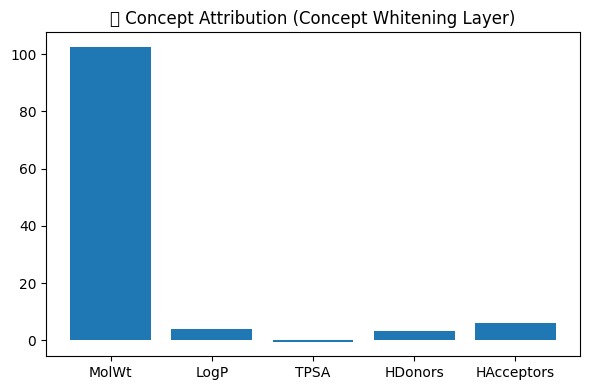


🔬 Molecule 797
⚠️ Node mask has constant values. Skipping visualization.


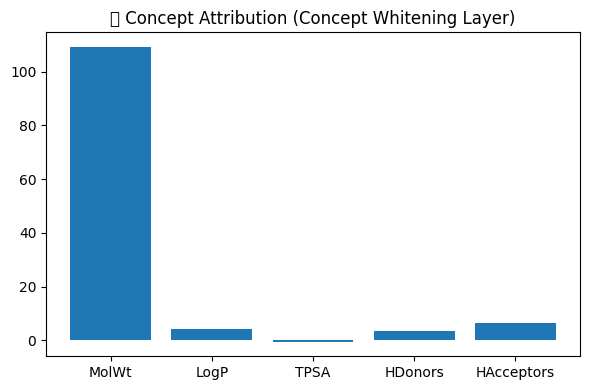


🔬 Molecule 798
⚠️ Node mask has constant values. Skipping visualization.


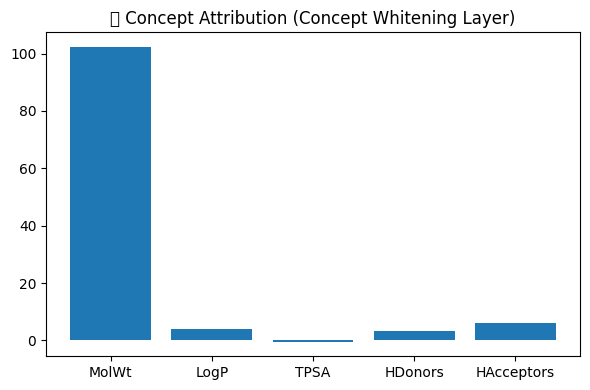


🔬 Molecule 799
⚠️ Node mask has constant values. Skipping visualization.


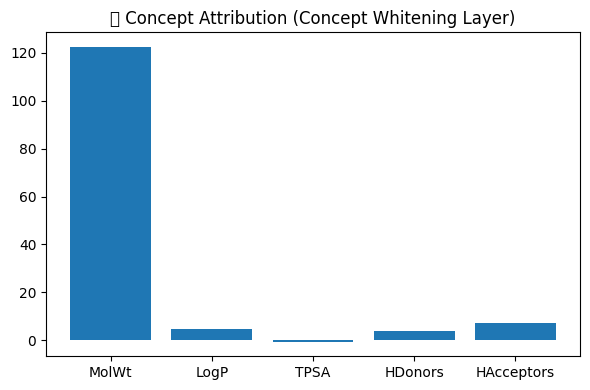


🔬 Molecule 800
⚠️ Node mask has constant values. Skipping visualization.


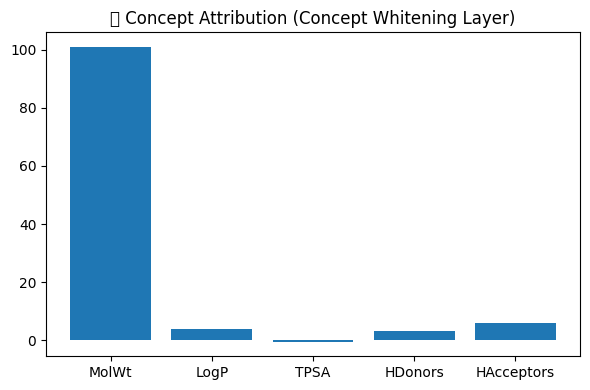

In [ ]:
# # Explanation utilities
# class WrappedModel(nn.Module):
#     def __init__(self, base_model, mol_features):
#         super().__init__()
#         self.base_model = base_model
#         self.mol_features = mol_features

#     def forward(self, x, edge_index, batch, **kwargs):
#         data = Data(x=x, edge_index=edge_index, batch=batch)
#         data.mol_features = self.mol_features
#         out, _ = self.base_model(data)
#         return out

# def visualize_rdkit_colored(smiles, node_mask):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         print("❌ Invalid SMILES:", smiles)
#         return

#     try:
#         node_mask = node_mask.cpu().detach().numpy()

#         # Handle NaN or Inf values
#         if np.isnan(node_mask).any() or np.isinf(node_mask).any():
#             print("⚠️ Node mask contains NaN or Inf values. Skipping visualization.")
#             return

#         # Avoid division by zero
#         if np.allclose(node_mask.max(), node_mask.min()):
#             print("⚠️ Node mask has constant values. Skipping visualization.")
#             return

#         # Normalize node mask
#         node_mask = (node_mask - node_mask.min()) / (node_mask.max() - node_mask.min() + 1e-8)
#         atom_weights = {i: float(node_mask[i]) for i in range(len(node_mask))}

#         # Generate the image
#         img = Draw.MolToImage(
#             mol,
#             size=(400, 300),
#             highlightAtoms=list(atom_weights.keys()),
#             highlightAtomColors={i: (1.0, 0.5 * w, 0.5 * w) for i, w in atom_weights.items()},
#         )

#         plt.figure(figsize=(4, 3))
#         plt.imshow(img)
#         plt.axis('off')
#         plt.title("RDKit Atom Attribution Map 🎨")
#         plt.show()

#     except Exception as e:
#         print("⚠️ RDKit Visualization Error:", e)

# def plot_concept_importance(model, data, device, concept_names=None):
#     model.eval()
#     data = data.to(device)
#     with torch.no_grad():
#         x, edge_index, batch = data.x, data.edge_index, data.batch
#         x = model.encoder(x, edge_index)
#         x = model.pool(x, batch)
#         concepts = model.cw_layer.proj(x) @ model.cw_layer.R
#         concepts = concepts[0].cpu().numpy()

#     if concept_names is None:
#         concept_names = ["MolWt", "LogP", "TPSA", "HDonors", "HAcceptors"]

#     plt.figure(figsize=(6, 4))
#     plt.bar(concept_names, concepts)
#     plt.title("📊 Concept Attribution (Concept Whitening Layer)")
#     plt.tight_layout()
#     plt.show()

# # Explanation loop
# print("\n🔍 Running Explainability on Last 5 Molecules...")
# last_five_indices = list(range(len(test_set) - 5, len(test_set)))

# for i in last_five_indices:
#     print(f"\n🔬 Molecule {i+1}")
#     sample = test_set[i].to(device)

#     # Skip small molecules
#     if len(sample.x) < 3:
#         print("⚠️ Skipping molecule with too few atoms")
#         continue

#     try:
#         wrapped_model = WrappedModel(model, mol_features=sample.mol_features).to(device)  # Ensure model is on the same device
#         explainer = Explainer(
#             model=wrapped_model,
#             algorithm=GNNExplainer(epochs=200),
#             explanation_type='model',
#             node_mask_type='attributes',
#             edge_mask_type='object',
#             model_config=ModelConfig(
#                 mode=ModelMode.binary_classification,
#                 task_level='graph',
#                 return_type=ModelReturnType.probs,
#             )
#         )

#         explanation = explainer(
#             x=sample.x,
#             edge_index=sample.edge_index,
#             batch=sample.batch
#         )

#         node_mask = explanation.node_mask
#         smiles = df_raw.iloc[train_idx[i]]['SMILES']  # Correct SMILES extraction
#         visualize_rdkit_colored(smiles, node_mask)
#         plot_concept_importance(model, sample, device)

#     except Exception as e:
#         print(f"⚠️ Failed to explain molecule {i}: {e}")

In [ ]:
# 🧪 Generate Concept Descriptor Table for Visualization
concept_table = []
for i, row in df_raw.iterrows():
    smi = row['SMILES']
    feats = compute_rdkit_features(smi)
    if feats:
        concept_table.append({
            "SMILES": smi,
            "TPSA": feats[0],
            "LogP": feats[1],
            "NumHDonors": feats[2],
            "NumAromaticRings": feats[3],
            "MolMR": feats[4],
        })

# 📊 Convert to DataFrame and display top rows
df_concepts = pd.DataFrame(concept_table)
print(f"✅ Generated concept table with {len(df_concepts)} molecules.")
df_concepts.head(10)  # Show first 10 entries


✅ Generated concept table with 4000 molecules.


,SMILES,TPSA,LogP,NumHDonors,NumAromaticRings,MolMR
0,C1CC(OC1)C(=O)NC2=CC3=C(C=C2)OC(=N3)C4=CC=CC=C4,64.36,3.61230,1,3,87.0487
1,CC1=CC2=C(C=C1)N=C(S2)C3=CC=C(C=C3)NC(=O)C(C)N...,79.37,4.89492,1,4,124.8267
2,C1CCN(CC1)C2=NC3=C(S2)C=C(C=C3)Cl,16.13,3.94000,0,1,70.6940
3,C1=CC=C(C=C1)OCC(=O)NC2=CC=CC=C2Cl,38.33,3.35750,1,4,72.0187
4,CCC1=CC2=C(C=C1)OC(=N2)C3=C(C=CC(=C3)N)Cl,52.05,4.29280,1,2,78.2454
5,CC(=O)C1=CC=C(C=C1)NC2=NN=C(C=C2)C3=CC=CC=C3F,54.88,4.22890,1,4,87.1552
6,CCN1CCN(CC1)C2=C(C=C(C=C2)NC(=O)C3=CC=C(O3)[N+...,91.86,3.23540,1,5,99.0946
7,C1=CC=C(C(=C1)NC2=NC(=CS2)C3=CN=CC=C3)Cl,37.81,4.60210,1,3,80.0797
8,CC1=C(SC(=N1)NC(=O)C2=CC=C(C=C2)C(C)(C)C)C(=O)C,59.06,4.20392,1,3,89.9507
9,CCOC(=O)C1=CC(=C(C=C1)OS(=O)(=O)C2=CC=CC=C2)OC,78.90,2.63960,0,6,83.2063


In [ ]:
# prompt: can you give  Molecule 730
#  data which is used for plotting?

# Assuming df_concepts is already created as in the provided code.
# Accessing data for Molecule 730 (index 729 in Python)
molecule_730_data = df_concepts.iloc[729]

# Extracting the desired data points for plotting
smiles = molecule_730_data['SMILES']
tpsa = molecule_730_data['TPSA']
logp = molecule_730_data['LogP']
num_hdonors = molecule_730_data['NumHDonors']
num_aromatic_rings = molecule_730_data['NumAromaticRings']
molmr = molecule_730_data['MolMR']

print(f"SMILES: {smiles}")
print(f"TPSA: {tpsa}")
print(f"LogP: {logp}")
print(f"NumHDonors: {num_hdonors}")
print(f"NumAromaticRings: {num_aromatic_rings}")
print(f"MolMR: {molmr}")


SMILES: CC1=C(N=CC=C1)NC2=NC(=CS2)C3=CC(=C(C=C3)O)O
TPSA: 78.27000000000001
LogP: 3.6683200000000022
NumHDonors: 3
NumAromaticRings: 3
MolMR: 83.13630000000003


In [ ]:
# prompt: df_concepts with negative values in data ( any one column is ok)

# Check for negative values in any column and print the first 10 rows with negative values.
negative_values_df = df_concepts[(df_concepts['TPSA'] < 0) | (df_concepts['LogP'] < 0) | (df_concepts['NumHDonors'] < 0) | (df_concepts['NumAromaticRings'] < 0) | (df_concepts['MolMR'] < 0)]
print(negative_values_df.head(10))


                                                 SMILES    TPSA     LogP  \
386                 C1C/C(=N\NC(=O)C(=O)N)/C2=CC=CC=C21   84.55 -0.06160   
600   CC1=CC2=C(C=C1)OC(=CC2=[NH+]C3=CC=CC=C3)C4=CC=...  128.58 -1.02618   
909             CC1=CC2=C(C=C1)[NH+]=C(C=C(N2)C)C.[Cl-]   26.00 -1.49868   
2174               CN1C2=C(C(=O)N(C1=O)C)N(C=N2)CC(CO)O  102.28 -2.21310   
2212  CC(=O)N1CCN(CC1)S(=O)(=O)C2=CC=CC(=C2)C(=O)OCC...  135.09 -0.00870   
2271  CCOC(=O)CCCCC(=O)C1=C(NC(=O)N1)C[N+]2=CC=CC=C2...   95.90 -1.65100   
2380        CCN(CC)S(=O)(=O)N1CCN(CC1)S(=O)(=O)N2CCOCC2   90.47 -1.23240   
2402  CN1C(=C(C(=O)N(C1=O)C)C(=O)COC(=O)C2=CC(=C(C=C...  131.85 -0.27690   
2545       CC1CN(C2=CC=CC=C2[N+]3=C1SC=C3C)C(=O)C.[Cl-]   24.19 -0.19278   
2589              CNC(=S)NNS(=O)(=O)C1=C(C=C(C=C1)OC)OC   88.69 -0.00900   

      NumHDonors  NumAromaticRings     MolMR  
386            2                 1   58.6371  
600            1                 3  103.1387  
909            2      

In [ ]:
negative_values_df


,SMILES,TPSA,LogP,NumHDonors,NumAromaticRings,MolMR
386,C1C/C(=N\NC(=O)C(=O)N)/C2=CC=CC=C21,84.55,-0.06160,2,1,58.6371
600,CC1=CC2=C(C=C1)OC(=CC2=[NH+]C3=CC=CC=C3)C4=CC=...,128.58,-1.02618,1,3,103.1387
909,CC1=CC2=C(C=C1)[NH+]=C(C=C(N2)C)C.[Cl-],26.00,-1.49868,2,0,59.8624
2174,CN1C2=C(C(=O)N(C1=O)C)N(C=N2)CC(CO)O,102.28,-2.21310,2,3,63.3076
2212,CC(=O)N1CCN(CC1)S(=O)(=O)C2=CC=CC(=C2)C(=O)OCC...,135.09,-0.00870,1,6,115.6235
2271,CCOC(=O)CCCCC(=O)C1=C(NC(=O)N1)C[N+]2=CC=CC=C2...,95.90,-1.65100,2,9,86.5839
2380,CCN(CC)S(=O)(=O)N1CCN(CC1)S(=O)(=O)N2CCOCC2,90.47,-1.23240,0,6,86.2986
2402,CN1C(=C(C(=O)N(C1=O)C)C(=O)COC(=O)C2=CC(=C(C=C...,131.85,-0.27690,1,6,95.4954
2545,CC1CN(C2=CC=CC=C2[N+]3=C1SC=C3C)C(=O)C.[Cl-],24.19,-0.19278,0,0,77.0300
2589,CNC(=S)NNS(=O)(=O)C1=C(C=C(C=C1)OC)OC,88.69,-0.00900,3,5,74.6609


In [ ]:
# prompt: negative_values_df with all values -ve

# Assuming df_concepts is already created as in the provided code.
negative_values_df = df_concepts[(df_concepts['TPSA'] < 0) & (df_concepts['LogP'] < 0) & (df_concepts['NumHDonors'] < 0) & (df_concepts['NumAromaticRings'] < 0) & (df_concepts['MolMR'] < 0)]
negative_values_df


,SMILES,TPSA,LogP,NumHDonors,NumAromaticRings,MolMR
